In [1]:
import pandas as pd

## 1. Initial Processing

In [70]:
data = pd.read_csv('sample_done_new.csv')
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'trans_date_trans_time', 'cc_num',
       'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'beyond_1std', 'beyond_2std', 'age', 'distance', 'trans_latenight',
       'trans_afternoon', 'trans_evening', 'trans_morning', 'trans_last24hr',
       'trans_last1hr'],
      dtype='object')

In [71]:
drop_columns = ['Unnamed: 0', 'Unnamed: 0.1','trans_date_trans_time', 'cc_num', 'merchant', 
                'category','first', 'last', 'street', 'city', 'state', 'zip',
                'lat', 'long', 'job', 'dob', 'trans_num', 'unix_time',
                'merch_lat', 'merch_long']
data.drop(drop_columns, axis=1, inplace=True)

#Remaining columns
data.columns

Index(['amt', 'gender', 'city_pop', 'is_fraud', 'beyond_1std', 'beyond_2std',
       'age', 'distance', 'trans_latenight', 'trans_afternoon',
       'trans_evening', 'trans_morning', 'trans_last24hr', 'trans_last1hr'],
      dtype='object')

In [72]:
data.head()

,amt,gender,city_pop,is_fraud,beyond_1std,beyond_2std,age,distance,trans_latenight,trans_afternoon,trans_evening,trans_morning,trans_last24hr,trans_last1hr
0,4.97,F,3495,0,False,False,31,593.360667,1,0,0,0,0,0
1,107.23,F,149,0,False,False,41,1729.247653,1,0,0,0,0,0
2,220.11,M,4154,0,True,False,57,6174.322485,1,0,0,0,0,0
3,45.00,M,1939,0,False,False,52,5645.702075,1,0,0,0,0,0
4,41.96,M,99,0,False,False,33,3760.455791,1,0,0,0,0,0


In [73]:
data['gender'] = data['gender'].map({'M': 0,'F': 1})
data['beyond_1std'] = data['beyond_1std'].map({False: 0, True: 1})
data['beyond_2std'] = data['beyond_2std'].map({False: 0, True: 1})

In [74]:
data.head()

,amt,gender,city_pop,is_fraud,beyond_1std,beyond_2std,age,distance,trans_latenight,trans_afternoon,trans_evening,trans_morning,trans_last24hr,trans_last1hr
0,4.97,1,3495,0,0,0,31,593.360667,1,0,0,0,0,0
1,107.23,1,149,0,0,0,41,1729.247653,1,0,0,0,0,0
2,220.11,0,4154,0,1,0,57,6174.322485,1,0,0,0,0,0
3,45.00,0,1939,0,0,0,52,5645.702075,1,0,0,0,0,0
4,41.96,0,99,0,0,0,33,3760.455791,1,0,0,0,0,0


## 2. Up-sample minority class to 20%

In [75]:
from sklearn.utils import resample

df_majority = data[data.is_fraud==0]
df_minority = data[data.is_fraud==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=29845,  # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.is_fraud.value_counts()

0    119380
1     29845
Name: is_fraud, dtype: int64

## 3. Enter Models

In [78]:
#Train valid test split
from sklearn.model_selection import train_test_split

X, y = df_upsampled.drop(['is_fraud'], axis=1), df_upsampled['is_fraud']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
X_train.head()

,amt,gender,city_pop,beyond_1std,beyond_2std,age,distance,trans_latenight,trans_afternoon,trans_evening,trans_morning,trans_last24hr,trans_last1hr
53610,11.14,0,5901,0,0,47,5503.917225,0,1,0,0,4,0
30688,24.03,1,1925,0,0,53,1855.096880,0,1,0,0,7,0
60472,1.45,1,46,0,0,33,5751.095883,0,0,1,0,8,1
57196,207.97,1,71485,1,0,45,2315.408114,0,0,0,1,19,0
14147,59.19,0,4081,0,0,81,4377.240908,0,0,0,1,1,0


### 3.1 Baseline: Random Guess

In [80]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

base_random = DummyClassifier(strategy = 'stratified', random_state=1211)
base_random.fit(X_train, y_train)
y_pred_base_random = base_random.predict(X_val)
y_pred_proba_base_random = base_random.predict_proba(X_val)[::,1]
fpr_base_random, tpr_base_random, thresholds_base_random = roc_curve(y_val, y_pred_proba_base_random)
auc_base_random = auc(fpr_base_random, tpr_base_random)

print(classification_report(y_val, y_pred_base_random))
print('F1 score:', f1_score(y_val,y_pred_base_random))
print('Precision:', precision_score(y_val,y_pred_base_random))
print('Recall:', recall_score(y_val,y_pred_base_random))
print('AUC:', auc_base_random)
print('Accuracy:', accuracy_score(y_val,y_pred_base_random))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81     23922
           1       0.21      0.21      0.21      5923

    accuracy                           0.69     29845
   macro avg       0.51      0.51      0.51     29845
weighted avg       0.69      0.69      0.69     29845

F1 score: 0.20849944863856137
Precision: 0.20951244459597682
Recall: 0.20749620124936688
AUC: 0.5068289467077869
Accuracy: 0.6873513151281622


### 3.2 Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier

base_tree = DecisionTreeClassifier(random_state=1211)
base_tree.fit(X_train,y_train)
y_pred_base_tree = base_tree.predict(X_val)
y_pred_proba_base_tree = base_tree.predict_proba(X_val)[::,1]
fpr_base_tree, tpr_base_tree, thresholds_base_tree = roc_curve(y_val, y_pred_proba_base_tree)
auc_base_tree = auc(fpr_base_tree, tpr_base_tree)

print(classification_report(y_val, y_pred_base_tree))
print('F1 score:', f1_score(y_val,y_pred_base_tree))
print('Precision:', precision_score(y_val,y_pred_base_tree))
print('Recall:', recall_score(y_val,y_pred_base_tree))
print('AUC:', auc_base_tree)
print('Accuracy:', accuracy_score(y_val,y_pred_base_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23922
           1       0.99      1.00      0.99      5923

    accuracy                           1.00     29845
   macro avg       0.99      1.00      1.00     29845
weighted avg       1.00      1.00      1.00     29845

F1 score: 0.9930421661497192
Precision: 0.9861804861804861
Recall: 1.0
AUC: 0.9982651952177912
Accuracy: 0.9972189646506953


### 3.3 Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

base_log = LogisticRegression(random_state=1211)
base_log.fit(X_train,y_train)
y_pred_base_log = base_log.predict(X_val)
y_pred_proba_base_log = base_log.predict_proba(X_val)[::,1]
fpr_base_log, tpr_base_log, thresholds_base_log = roc_curve(y_val, y_pred_proba_base_log)
auc_base_log = auc(fpr_base_log, tpr_base_log)

print(classification_report(y_val, y_pred_base_log))
print('F1 score:', f1_score(y_val,y_pred_base_log))
print('Precision:', precision_score(y_val,y_pred_base_log))
print('Recall:', recall_score(y_val,y_pred_base_log))
print('AUC:', auc_base_log)
print('Accuracy:', accuracy_score(y_val,y_pred_base_log))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     23922
           1       0.88      0.50      0.64      5923

    accuracy                           0.89     29845
   macro avg       0.88      0.74      0.79     29845
weighted avg       0.89      0.89      0.87     29845

F1 score: 0.6381054897739505
Precision: 0.8803088803088803
Recall: 0.5004220834036806
AUC: 0.8218387611614612
Accuracy: 0.8873513151281621


### 3.4 Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[50,100], 'max_depth':[None, 5, 10]}
rf = GridSearchCV(RandomForestClassifier(random_state=1211, oob_score=True, class_weight='balanced_subsample'), parameters, scoring='f1')
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_val)
y_pred_proba_rf = rf.predict_proba(X_val)[::,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, y_pred_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

print(classification_report(y_val, y_pred_rf))
print('F1 score:', f1_score(y_val,y_pred_rf))
print('Precision:', precision_score(y_val,y_pred_rf))
print('Recall:', recall_score(y_val,y_pred_rf))
print('AUC:', auc_rf)
print('Accuracy:', accuracy_score(y_val,y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23922
           1       1.00      1.00      1.00      5923

    accuracy                           1.00     29845
   macro avg       1.00      1.00      1.00     29845
weighted avg       1.00      1.00      1.00     29845

F1 score: 0.9981462756993597
Precision: 0.9962994112699748
Recall: 1.0
AUC: 1.0
Accuracy: 0.9992628581001843


## 4. Feature Importance from Tree-based

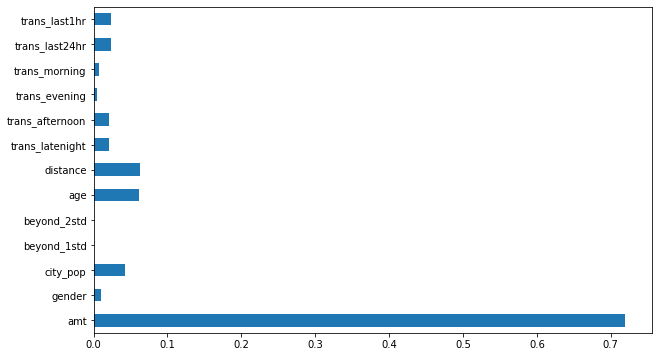

In [86]:
import matplotlib.pyplot as plt

base_tree = DecisionTreeClassifier(random_state=1211)
base_tree.fit(X,y)

plt.figure(figsize=(10,6))
feat_importances = pd.Series(base_tree.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()